In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Путь к файлу

In [2]:
TRAIN_PATH = r"C:\Users\79031\Desktop\GeekBrains\Библиотеки Python для Data Science\final_proj\train.csv"
TEST_PATH = r"C:\Users\79031\Desktop\GeekBrains\Библиотеки Python для Data Science\final_proj\test.csv"
PREP_PATH = r"C:\Users\79031\Desktop\GeekBrains\Библиотеки Python для Data Science\final_proj\Submission.csv"

## 1. Чтение данных

In [3]:
X = pd.read_csv(TRAIN_PATH)
X_final = pd.read_csv(TEST_PATH)
X.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

### 1.1 Обработка индексов

In [4]:
X.set_index('Id', inplace=True)
X['DistrictId'] = X['DistrictId'].astype(str)
# df['DistrictId'] = df['DistrictId'].astype('category')
X_final['DistrictId'] = X_final['DistrictId'].astype(str)
# X_final['DistrictId'] = X_final['DistrictId'].astype('category')
X_final.set_index('Id', inplace=True)
X_final.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
725           58    2.0  49.882643   33.432782            6.0      6   
15856         74    2.0  69.263183         NaN            1.0      6   
5480         190    1.0  13.597819   15.948246           12.0      2   
15664         47    2.0  73.046609   51.940842            9.0     22   
14275         27    1.0  47.527111   43.387569            1.0     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
725          14.0       1972   0.310199         B         B        11   
15856         1.0       1977   0.075779         B         B         6   
5480          5.0       1909   0.000000         B         B        30   
15664        22.0       2007   0.101872         B         B        23   
14275        17.0       2017   0.072158         B         B         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
Id                                                                     
725        2748         1           NaN            0        0       B  
15856      1437         3           NaN            0        2       B  
5480       7538        87        4702.0            5        5       B  
15664      4583         3           NaN            3        3       B  
14275       629         1           NaN            0        0       A

In [5]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### 1.2 Reduce Map

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
reduce_mem_usage(X)
reduce_mem_usage(X_final)
X.dtypes

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.56 MB
Decreased by 63.6%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.25 MB
Decreased by 64.9%


DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

## 1.3 EDA:
a) NaN                                                                                                 
b) Выбросы                                                                                                                                                                            

### a) NaN

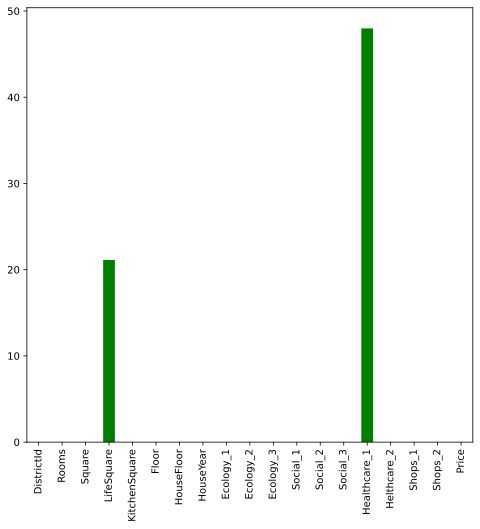

In [8]:
df_nan = (X.isna().sum() / X.shape[0]) * 100
plt.figure(figsize=(8, 8))
df_nan.plot(kind='bar', color='green')
plt.show()



# Healthcare_1 - удалить
# LifeSquare - заполнить как Square - KitchenSquare => сначала посмотреть KitchenSquare
# LifeSquare - заменяем > 1000 на медиану
# LifeSquare < 10 на медиану

### b) Количественные признаки. Выбросы

In [9]:
df_num_features = X.select_dtypes(include=['float32', 'int8', 'int16', 'int32'])
df_num_features

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
Id                                                                      
14038    2.0  47.981560   29.442751            6.0      7         9.0   
15053    3.0  65.683640   40.049541            8.0      7         9.0   
4765     2.0  44.947952   29.197611            0.0      8        12.0   
5809     2.0  53.352982   52.731510            9.0      8        17.0   
10783    1.0  39.649193   23.776169            7.0     11        12.0   
...      ...        ...         ...            ...    ...         ...   
77       2.0  50.401787   30.476204            5.0      6         5.0   
6159     1.0  41.521545   20.539215            9.0     13        13.0   
5123     1.0  47.939007         NaN            1.0     12        16.0   
5400     2.0  43.602562   33.840149            8.0      1         5.0   
6306     1.0  38.666645   21.157875            8.0      7        17.0   

       HouseYear  Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  \
Id                                                                        
14038       1969   0.089040        33      7976         5           NaN   
15053       1978   0.000070        46     10309         1         240.0   
4765        1968   0.049637        34      7759         0         229.0   
5809        1977   0.437885        23      5735         3        1084.0   
10783       1976   0.012339        35      5776         1        2078.0   
...          ...        ...       ...       ...       ...           ...   
77          1968   0.135650        46      7960         6         350.0   
6159        2000   0.000000        30      5562         0           NaN   
5123        2015   0.072158         2       629         1           NaN   
5400        1961   0.307467        30      5048         9         325.0   
6306        1990   0.000000        27      4798         0          30.0   

       Helthcare_2  Shops_1          Price  
Id                                          
14038            0       11  184966.937500  
15053            1       16  300009.437500  
4765             1        3  220925.906250  
5809             0        5  175616.234375  
10783            2        4  150226.531250  
...            ...      ...            ...  
77               3       11  196684.312500  
6159             0        5  189050.296875  
5123             0        0  159143.812500  
5400             2        5  181595.343750  
6306             2        8  218714.078125  

[10000 rows x 15 columns]

#### KitchenSquare

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64


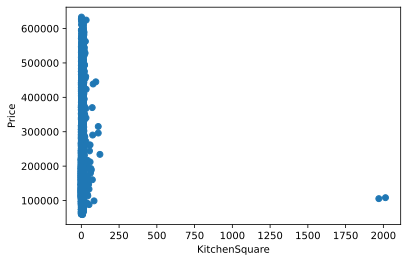

In [10]:
print(df_num_features['KitchenSquare'].value_counts().sort_values())
plt.scatter(df_num_features['KitchenSquare'], df_num_features['Price'])
plt.ylabel('Price')
plt.xlabel('KitchenSquare')
plt.show()






# Минимальный размер кухни - 6 кв метров по строительному кодексу => <6 = 6
# > 1000 = // 10

### Square

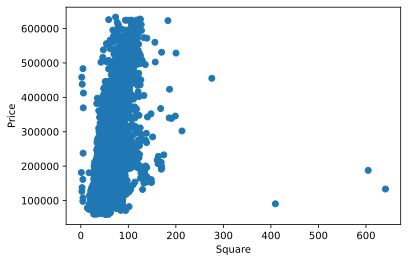

         Square  LifeSquare  KitchenSquare
Id                                        
1748   5.497061   67.628716            1.0
11526  4.633498    1.969969            1.0
10202  2.596351    4.604943            1.0
10527  4.380726   40.805836            1.0
9487   5.129221    5.549458            1.0
3224   2.377248    0.873147            0.0
4504   4.390331    5.610772            1.0
14786  1.136859    4.525736            1.0
13265  4.823679   79.767967            0.0
15744  1.988943    2.642219            1.0
6782   2.954309    5.257278            1.0
7657   4.502784    4.618547            1.0


Square  LifeSquare  KitchenSquare
Id                                          
8054    42.530045   43.967758            1.0
10521  104.211395  106.340401            0.0
2301    61.400055   65.224602            0.0
8753    85.952309   89.803749            1.0
9870    51.831474   53.491302            1.0
...           ...         ...            ...
41      59.015896   59.439083           12.0
12918   51.440464   53.134243           51.0
2737   123.430069  125.806984          123.0
14001   44.098766   44.267551            1.0
16568  200.334534  201.627365           25.0

[482 rows x 3 columns]

In [11]:
df_num_features['Square'].value_counts()
plt.scatter(df_num_features['Square'], df_num_features['Price'])
plt.ylabel('Price')
plt.xlabel('Square')
plt.show()

print(df_num_features.loc[df_num_features['Square'] < 10, ['Square', 'LifeSquare', 'KitchenSquare']])

df_num_features.loc[df_num_features['Square']  <= df_num_features['LifeSquare'],
                    ['Square', 'LifeSquare', 'KitchenSquare']]









# Square ≈ LifeSquare + KitchenSquare
# Square <= LifeSquare заменяем на LifeSqaure + KitchenSquare
# Square < 10 меняем на медиану

In [12]:
df_num_features.loc[df_num_features['Square'] > 400, ['Square', 'LifeSquare', 'KitchenSquare']]

Square  LifeSquare  KitchenSquare
Id                                          
28     604.705994         NaN            1.0
2307   409.425171  410.639740           10.0
11602  641.065186  638.163208           10.0

### LifeSqaure 

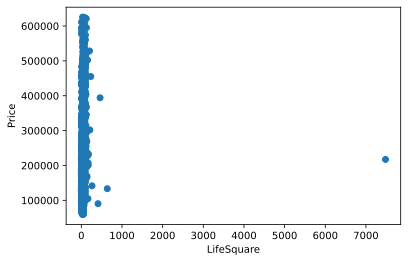

LifeSquare      Square  KitchenSquare
Id                                           
16550  7480.592285   81.694420            1.0
11602   638.163208  641.065186           10.0

In [13]:
plt.scatter(df_num_features['LifeSquare'], df_num_features['Price'])
plt.ylabel('Price')
plt.xlabel('LifeSquare')
plt.show()

df_num_features.loc[df_num_features['LifeSquare'] > 600, ['LifeSquare', 'Square', 'KitchenSquare']]





# LifeSquare - заполнить как Square - KitchenSquare => сначала посмотреть KitchenSquare
# LifeSquare - заменяем > 1000 на медиану
# LifeSquare < 10 на медиану

### Rooms

In [14]:
df_num_features['Rooms'].value_counts()




# >= 6 - меняем на медиану
# == 0 - меняем на 1

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

### HouseYear

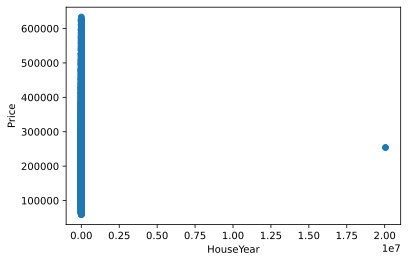

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [15]:
plt.scatter(df_num_features['HouseYear'], df_num_features['Price'])
plt.ylabel('Price')
plt.xlabel('HouseYear')
plt.show()

df_num_features['HouseYear'].sort_values().unique()






# > 2020 - меняем на 2020

### HouseFloor, Floor

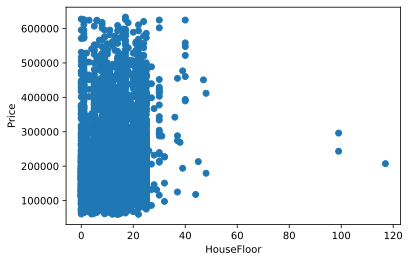

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  36.  37.  38.  39.  40.  44.  45.  47.  48.
  99. 117.]


Floor  HouseFloor
Id                      
11993     14         0.0
10953      5         4.0
2119       6         5.0
11935     15         1.0
6641       2         0.0
...      ...         ...
2237      11         9.0
16159     10         1.0
4145      26        24.0
11553     18        17.0
77         6         5.0

[1825 rows x 2 columns]

In [16]:
plt.scatter(df_num_features['HouseFloor'], df_num_features['Price'])
plt.ylabel('Price')
plt.xlabel('HouseFloor')
plt.show()

print(df_num_features['HouseFloor'].sort_values().unique())

df_num_features.loc[df_num_features['Floor']  > df_num_features['HouseFloor'] , ['Floor', 'HouseFloor']]



# HouseFloor > 50 - меняем на медиану
# Floor > HouseFloor - меняем на HouseFloor

In [17]:
print(df_num_features.loc[df_num_features['Floor']  > df_num_features['HouseFloor'] , ['Floor', 'HouseFloor']])

       Floor  HouseFloor
Id                      
11993     14         0.0
10953      5         4.0
2119       6         5.0
11935     15         1.0
6641       2         0.0
...      ...         ...
2237      11         9.0
16159     10         1.0
4145      26        24.0
11553     18        17.0
77         6         5.0

[1825 rows x 2 columns]


### Категориальные параметры

In [18]:
df_object_features = X.select_dtypes(include='category')
df_object_features

# Ecology, Shops - сделать бинарными

DistrictId Ecology_2 Ecology_3 Shops_2
Id                                          
14038         35         B         B       B
15053         41         B         B       B
4765          53         B         B       B
5809          58         B         B       B
10783         99         B         B       B
...          ...       ...       ...     ...
77            32         B         B       B
6159          18         B         B       A
5123          27         B         B       A
5400          75         B         A       B
6306         128         B         B       B

[10000 rows x 4 columns]

In [19]:
dict(df_object_features['DistrictId'].sort_values().value_counts())

# Отобрать >50

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '99': 97,
 '101': 97,
 '13': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '88': 64,
 '128': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '124': 43,
 '129': 43,
 '42': 42,
 '79': 42,
 '113': 41,
 '109': 41,
 '77': 40,
 '54': 37,
 '15': 36,
 '38': 36,
 '24': 35,
 '32': 34,
 '56': 34,
 '5': 34,
 '103': 33,
 '123': 32,
 '80': 31,
 '19': 31,
 '33': 31,
 '83': 31,
 '69': 29,
 '130': 29,
 '138': 29,
 '64': 28,
 '70': 27,
 '86': 27,
 '87': 27,
 '108': 

## 2. Очистка данных

In [20]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 6, 'KitchenSquare'] = 6
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] >
                                                                  1000, 'KitchenSquare'] // 10

        # LifeSquare
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition,'Square'] - X.loc[condition, 'KitchenSquare']
        X.loc[X['LifeSquare'] > 1000, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = self.medians['LifeSquare']

        
        # Square
        X.loc[X['Square']  <=
              X['LifeSquare'], 'Square'] = (X.loc[X['Square']  < X['LifeSquare'], 'LifeSquare'] +
                                            X.loc[X['Square']  < X['LifeSquare'], 'KitchenSquare'])
        X.loc[X['Square'] < 10, 'Square'] = self.medians['Square']
        
        
        # Rooms
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        
        #HouseFloor
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor']  > X['HouseFloor'] , 'Floor'] = X.loc[X['Floor']  > X['HouseFloor'] ,'HouseFloor']  
        
        return X

In [21]:
imputer = FeatureImputer()

imputer.fit(X)
X = imputer.transform(X)

X_final = imputer.transform(X_final)
X_final

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
725           58    2.0  49.882645   33.432781            6.0    6.0   
15856         74    2.0  69.263184   63.263184            6.0    1.0   
5480         190    1.0  27.948246   15.948246           12.0    2.0   
15664         47    2.0  73.046608   51.940842            9.0   22.0   
14275         27    1.0  47.527111   43.387569            6.0   17.0   
...          ...    ...        ...         ...            ...    ...   
8180          11    3.0  67.133911   50.809795            6.0    5.0   
4695           1    1.0  40.198471   21.807060           10.0   12.0   
5783          12    3.0  77.842178   48.282623            9.0   22.0   
4780          62    2.0  81.305222   75.305222            6.0    0.0   
12504         30    2.0  60.555695   54.555695            6.0   10.0   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
725          14.0       1972   0.310199         B         B        11   
15856         1.0       1977   0.075779         B         B         6   
5480          5.0       1909   0.000000         B         B        30   
15664        22.0       2007   0.101872         B         B        23   
14275        17.0       2017   0.072158         B         B         2   
...           ...        ...        ...       ...       ...       ...   
8180          9.0       1973   0.000170         B         B        36   
4695         17.0       2017   0.007122         B         B         1   
5783         22.0       1989   0.090799         B         B        74   
4780          0.0       1977   0.072158         B         B         2   
12504        17.0       1977   0.000078         B         B        22   

       Social_2  Social_3  Helthcare_2  Shops_1 Shops_2  
Id                                                       
725        2748         1            0        0       B  
15856      1437         3            0        2       B  
5480       7538        87            5        5       B  
15664      4583         3            3        3       B  
14275       629         1            0        0       A  
...         ...       ...          ...      ...     ...  
8180       5992         0            1        1       B  
4695        264         0            0        1       B  
5783      19083         2            5       15       B  
4780        629         1            0        0       A  
12504      6398       141            3       23       B  

[5000 rows x 17 columns]

### Отделяем target от данных

In [22]:
y = X[['Price']]
X.drop('Price', axis=1, inplace=True)


## 3.Feature engeneering

In [23]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.med_price_by_rooms_in_district = None
        self.med_price_by_square = None
        self.med_price_by_year_cat = None
        self.med_price_by_shops_1_cat = None
        
    def fit(self, X, y=None):
        working_df = X.copy()
        
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50] 
        self.DistrictId_counts = dict(district)
        
        working_df['DistrictId_popularity'] = working_df['DistrictId'].map(district)
        working_df['DistrictId_popularity'].fillna(5, inplace=True)
        
        
        # Year_cat
        working_df = self.year_to_cat(working_df)
        
        # Shops_1 cat
        working_df = self.shops1_to_cat(working_df)
        
        # HouseFloor_cat
        working_df = self.housefloor_to_cat(working_df)
        
        
        # Target encoding
        ## MedPriceByRoomsInDistrict
        if y is not None:
            working_df['Price'] = y.values
            df = working_df.loc[working_df['DistrictId_popularity'] > 5, ['DistrictId', 'Price', 'Rooms']]
            self.med_price_by_rooms_in_district = df.groupby(['DistrictId', 'Rooms']).agg(
                {'Price':'median'}).rename(columns={'Price':'MedPriceByRooms'})   
        
        
        ## MedPriceBySquareInDistrict
            df_1 = working_df.loc[working_df['DistrictId_popularity'] > 5, ['DistrictId', 'Price', 'Square']]
            df_1 = df_1.groupby(['DistrictId']).agg({'Square': 'median', 'Price':'median'})
            df_1['Price'] = df_1['Price'] / df_1['Square']
            df_1.rename(columns={'Price':'MedPriceBySquare'}, inplace=True)  
            df_1.drop('Square', axis=1, inplace=True)
            self.med_price_by_square = df_1

            
        ## MedPriceByYearCat
            year_cat_df = working_df[['Year_cat', 'Price']]
            year_cat_df = year_cat_df.groupby(['Year_cat']).agg({'Price':'median'})
            year_cat_df.rename(columns={'Price':'MedPriceByYearCat'}, inplace=True)
            self.med_price_by_year_cat = year_cat_df
        
        
        ## MedPriceByShops1cat
            price_by_shops_df = working_df[['Shops_1_cat', 'Price']]
            self.med_price_by_shops_1_cat = price_by_shops_df.groupby(['Shops_1_cat']).agg({
                'Price':'median'}).rename(columns={'Price':'MedPriceByShops_1_cat'})   
            
            
        return X

    def transform(self, X):
        
        # DistrictId
        X['DistrictId_popularity'] = X['DistrictId'].map(self.DistrictId_counts)
        X['DistrictId_popularity'].fillna(5, inplace=True)
        
        
        # MedEcology_1ByDistrict
        ecology_df = X.loc[X['DistrictId_popularity'] > 5, ['DistrictId', 'Ecology_1']]
        ecology_df = ecology_df.groupby(['DistrictId']).agg({'Ecology_1': 'median'}).rename(
            columns={'Ecology_1':'MedEcology_1ByDistrict'})
        X = X.reset_index().merge(ecology_df, on='DistrictId', how='left').set_index('Id')
        
        
        # Percentage of LifeSquare in the Square
        X['LifeSquare_share'] = X['LifeSquare'] / X['Square'] * 100
        
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        
        # More categorical features
        X = self.floor_to_cat(X)       # + столбец floor_cat
        X = self.year_to_cat(X)        # + столбец year_cat
        X = self.housefloor_to_cat(X)  # + столбец housefloor_cat
        X = self.shops1_to_cat(X)      # + столбец shops_1_cat
        
        
        # Target encoding
        if self.med_price_by_rooms_in_district is not None:
            X = X.reset_index().merge(self.med_price_by_rooms_in_district, on=[
                'DistrictId', 'Rooms'], how='left').set_index('Id')
        if self.med_price_by_square is not None:
            X = X.reset_index().merge(self.med_price_by_square, on=['DistrictId'], how='left').set_index('Id')
        if self.med_price_by_year_cat is not None:
            X = X.reset_index().merge(self.med_price_by_year_cat, on=['Year_cat'], how='left').set_index('Id')
        if self.med_price_by_shops_1_cat is not None:
            X = X.reset_index().merge(self.med_price_by_shops_1_cat, on=['Shops_1_cat'], how='left').set_index('Id')
        
        
        return X
    
    
    def floor_to_cat(self, X):
        X['Floor_cat'] = np.nan

        X.loc[X['Floor'] <= 2, 'Floor_cat'] = 1
        X.loc[(X['Floor'] > 2) & (X['Floor'] <= 5), 'Floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'Floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 12), 'Floor_cat'] = 4
        X.loc[(X['Floor'] > 12) & (X['Floor'] <= 16), 'Floor_cat'] = 5
        X.loc[(X['Floor'] > 16), 'Floor_cat'] = 6

        X['Floor_cat'] = X['Floor_cat'].astype(str)
        X['Floor_cat'] = X['Floor_cat'].astype('category')

        return X


    def housefloor_to_cat(self, X):
        X['HouseFloor_cat'] = np.nan

        X.loc[X['HouseFloor'] <= 2, 'HouseFloor_cat'] = 1
        X.loc[(X['HouseFloor'] > 2) & (X['HouseFloor'] <= 5), 'HouseFloor_cat'] = 2
        X.loc[(X['HouseFloor'] > 5) & (X['HouseFloor'] <= 9), 'HouseFloor_cat'] = 3
        X.loc[(X['HouseFloor'] > 9) & (X['HouseFloor'] <= 12), 'HouseFloor_cat'] = 4
        X.loc[(X['HouseFloor'] > 12) & (X['HouseFloor'] <= 16), 'HouseFloor_cat'] = 5
        X.loc[(X['HouseFloor'] > 16), 'HouseFloor_cat'] = 6

        X['HouseFloor_cat'] = X['HouseFloor_cat'].astype(str)
        X['HouseFloor_cat'] = X['HouseFloor_cat'].astype('category')

        return X
    
    
    def year_to_cat(self, X):
        X['Year_cat'] = np.nan

        X.loc[X['HouseYear'] < 1941, 'Year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] < 1950), 'Year_cat'] = 2
        X.loc[(X['HouseYear'] >= 1950) & (X['HouseYear'] < 1980), 'Year_cat'] = 3
        X.loc[(X['HouseYear'] >= 1980) & (X['HouseYear'] < 2000), 'Year_cat'] = 4
        X.loc[(X['HouseYear'] >= 2000) & (X['HouseYear'] < 2010), 'Year_cat'] = 5
        X.loc[(X['HouseYear'] >= 2010), 'Year_cat'] = 6

        X['Year_cat'] = X['Year_cat'].astype(str)
        X['Year_cat'] = X['Year_cat'].astype('category')

        return X
    
    
    def shops1_to_cat(self, X):
        X['Shops_1_cat'] = np.nan

        X.loc[X['Shops_1'] <= 4, 'Shops_1_cat'] = 1  
        X.loc[(X['Shops_1'] > 4) & (X['Shops_1'] <= 8), 'Shops_1_cat'] = 2
        X.loc[(X['Shops_1'] > 8) & (X['Shops_1'] <= 12), 'Shops_1_cat'] = 3
        X.loc[(X['Shops_1'] > 12) & (X['Shops_1'] <= 16), 'Shops_1_cat'] = 4
        X.loc[X['Shops_1'] > 16, 'Shops_1_cat'] = 5

        X['Shops_1_cat'] = X['Shops_1_cat'].astype(str)
        X['Shops_1_cat'] = X['Shops_1_cat'].astype('category')
        
        return X

In [24]:
features = FeatureGenetator()
features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)
X_final

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
725           58    2.0  49.882645   33.432781            6.0    6.0   
15856         74    2.0  69.263184   63.263184            6.0    1.0   
5480         190    1.0  27.948246   15.948246           12.0    2.0   
15664         47    2.0  73.046608   51.940842            9.0   22.0   
14275         27    1.0  47.527111   43.387569            6.0   17.0   
...          ...    ...        ...         ...            ...    ...   
8180          11    3.0  67.133911   50.809795            6.0    5.0   
4695           1    1.0  40.198471   21.807060           10.0   12.0   
5783          12    3.0  77.842178   48.282623            9.0   22.0   
4780          62    2.0  81.305222   75.305222            6.0    0.0   
12504         30    2.0  60.555695   54.555695            6.0   10.0   

       HouseFloor  HouseYear  Ecology_1 Ecology_2  ... MedEcology_1ByDistrict  \
Id                                                 ...                          
725          14.0       1972   0.310199         1  ...               0.437885   
15856         1.0       1977   0.075779         1  ...               0.075779   
5480          5.0       1909   0.000000         1  ...                    NaN   
15664        22.0       2007   0.101872         1  ...               0.101872   
14275        17.0       2017   0.072158         1  ...               0.072158   
...           ...        ...        ...       ...  ...                    ...   
8180          9.0       1973   0.000170         1  ...               0.000170   
4695         17.0       2017   0.007122         1  ...               0.007122   
5783         22.0       1989   0.090799         1  ...               0.090799   
4780          0.0       1977   0.072158         1  ...               0.072158   
12504        17.0       1977   0.000078         1  ...               0.000078   

       LifeSquare_share  Floor_cat  Year_cat  HouseFloor_cat  Shops_1_cat  \
Id                                                                          
725           67.022873        3.0       3.0             5.0          1.0   
15856         91.337387        1.0       3.0             1.0          1.0   
5480          57.063496        1.0       1.0             2.0          2.0   
15664         71.106438        6.0       5.0             6.0          1.0   
14275         91.290146        6.0       6.0             6.0          1.0   
...                 ...        ...       ...             ...          ...   
8180          75.684250        2.0       3.0             3.0          1.0   
4695          54.248482        4.0       6.0             6.0          1.0   
5783          62.026299        6.0       4.0             6.0          4.0   
4780          92.620399        1.0       3.0             1.0          1.0   
12504         90.091766        4.0       3.0             6.0          5.0   

      MedPriceByRooms  MedPriceBySquare  MedPriceByYearCat  \
Id                                                           
725     166809.671875       2920.934082      184415.468750   
15856   243031.687500       3415.686279      184415.468750   
5480              NaN               NaN      352702.625000   
15664   222227.593750       3821.027588      247611.343750   
14275   118349.687500       2633.131836      178467.109375   
...               ...               ...                ...   
8180    247249.093750       4193.582031      184415.468750   
4695    146735.671875       2993.085449      178467.109375   
5783    315198.843750       3908.126465      224277.828125   
4780    178912.375000       2807.932373      184415.468750   
12504   177914.718750       2654.074219      184415.468750   

       MedPriceByShops_1_cat  
Id                            
725            182228.515625  
15856          182228.515625  
5480           207221.656250  
15664          182228.515625  
14275          18222

In [25]:
X['DistrictId'] = X['DistrictId'].astype(str)
X['DistrictId'] = X['DistrictId'].astype('category')

X_final['DistrictId'] = X_final['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype('category')

## 4. Модель

In [26]:
model = LGBMRegressor(criterion='mse',
                            max_depth=10,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=100)

### Отладка модели

In [27]:
params = {'n_estimators':[50, 100, 150, 200], 

          'max_depth': [5, 10, 15, 20, 25, 30],
          'min_samples_leaf':[10, 15, 20, 25, 30, 35, 40]}

gs = GridSearchCV(model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=5,   
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  
                 )

# gs.fit(X, y)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=LGBMRegressor(criterion='mse', max_depth=10,
                                     min_samples_leaf=10, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [28]:
# gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}

## Для теста

In [29]:
X.drop('Ecology_2', axis=1, inplace=True)
X_final.drop('Ecology_2', axis=1, inplace=True)


In [30]:
model.fit(X, y)

LGBMRegressor(criterion='mse', max_depth=10, min_samples_leaf=10,
              random_state=42)

In [31]:
y_test_predicts = pd.DataFrame(model.predict(X_final), columns=['Price'])

y_test_predicts

Price
0     143714.160157
1     233408.702959
2     214884.327344
3     306987.278208
4     134395.595172
...             ...
4995  252229.699846
4996  131685.090781
4997  318912.012799
4998  192717.027153
4999  177886.417344

[5000 rows x 1 columns]

## Создаем дф + отправляем в файл

In [32]:
res = X_final.reset_index()
res = res[['Id']]
res = pd.concat([res, y_test_predicts], axis=1)
res

Id          Price
0       725  143714.160157
1     15856  233408.702959
2      5480  214884.327344
3     15664  306987.278208
4     14275  134395.595172
...     ...            ...
4995   8180  252229.699846
4996   4695  131685.090781
4997   5783  318912.012799
4998   4780  192717.027153
4999  12504  177886.417344

[5000 rows x 2 columns]

In [33]:
res.to_csv(PREP_PATH, index=False, encoding='utf-8')
res

Id          Price
0       725  143714.160157
1     15856  233408.702959
2      5480  214884.327344
3     15664  306987.278208
4     14275  134395.595172
...     ...            ...
4995   8180  252229.699846
4996   4695  131685.090781
4997   5783  318912.012799
4998   4780  192717.027153
4999  12504  177886.417344

[5000 rows x 2 columns]

In [34]:
feature_importances = pd.DataFrame(zip(X_final.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

feature_name  importance
2                   Square    0.142333
0               DistrictId    0.125333
7                HouseYear    0.091333
18        LifeSquare_share    0.077000
3               LifeSquare    0.066333
8                Ecology_1    0.056333
12                Social_3    0.053333
6               HouseFloor    0.050333
23         MedPriceByRooms    0.047333
4            KitchenSquare    0.045333
5                    Floor    0.043667
10                Social_1    0.033667
11                Social_2    0.030000
24        MedPriceBySquare    0.024000
25       MedPriceByYearCat    0.022333
14                 Shops_1    0.018333
21          HouseFloor_cat    0.016667
13             Helthcare_2    0.012667
17  MedEcology_1ByDistrict    0.012667
1                    Rooms    0.009333
16   DistrictId_popularity    0.008000
20                Year_cat    0.005333
19               Floor_cat    0.005000
26   MedPriceByShops_1_cat    0.001667
15                 Shops_2    0.001333
22             Shops_1_cat    0.000333
9                Ecology_3    0.000000